In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch
from matplotlib.lines import Line2D

print(torch.cuda.is_available())

True


In [2]:
def load_h5_as_tensor(dir_name='/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5'):
    dataset = Dataset4h5(dir_name, num_image=192, num_redshift=64, HII_DIM=64, rescale=False, dim=2)

    with h5py.File(dir_name) as f:
        print(f.keys())
        print(f['redshifts_distances'])
        los = f['redshifts_distances'][:,-dataset.num_redshift:]

    dataloader = DataLoader(dataset, batch_size=192)
    
    x, c = next(iter(dataloader))
    print("x.shape =", x.shape)
    print("c.shape =", c.shape)
    print("x.min() =", x.min())
    print("x.max() =", x.max())
    return x, c, los

In [3]:
x0208, c0208, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5')
x0802, c0802, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.6-19.037.h5')
x0000, c0000, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5')

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
images rescaled to [0.0, 41.84291076660156]
params rescaled to [4.4, 131.341]
<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">
x.shape = torch.Size([192, 1, 64, 64])
c.shape = torch.Size([192, 2])
x.min() = tensor(0.)
x.max() = tensor(41.8429)
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
imag

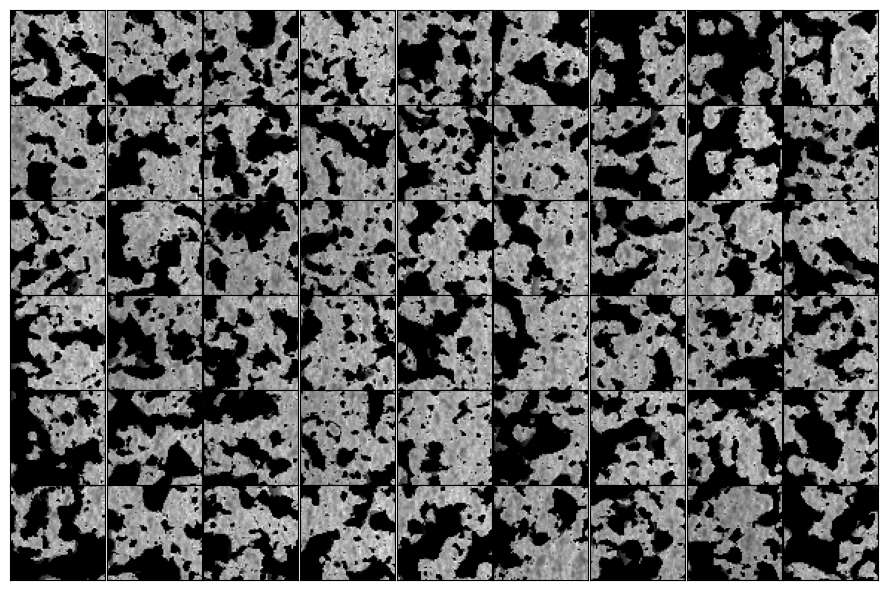

In [4]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot_grid(samples, row=6, col=9):
    plt.figure(figsize = (9,6))
    for i in range(54):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    # plt.suptitle('simulations')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    
plot_grid(x0208[:,:,:,:])

In [5]:
# sigma_level = 68.27
# print(x0208.shape) 
# print(los.shape)
# Tb = x0208[:,0].mean(axis=1)
# plt.plot(los[0], np.median(Tb, axis=0))
# plt.fill_between(los[0], np.percentile(Tb, 100-sigma_level, axis=0), np.percentile(Tb, sigma_level, axis=0), alpha=0.2)
# # for i in range(24):
# #     plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# # plt.plot(los[0,:], Tb[1,0,:])
# # plt.plot(los[0,:], Tb[2,0,:])
# # plt.yscale('log')
# plt.grid()
# plt.ylabel('Tb [mK]')
# plt.xlabel('z')
# plt.show()

In [6]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (4*np.pi**2)

    return kbins, Pk

In [7]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
def x2Pk(x):
    Pk_vals_all = []
    for i in range(54):
        density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all
    # Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [8]:
k_vals, Pk_vals_all_sim_0208 = x2Pk(x0208)
k_vals, Pk_vals_all_sim_0802 = x2Pk(x0802)
k_vals, Pk_vals_all_sim_0000 = x2Pk(x0000)

In [9]:
ll -lth outputs

total 879M
-rw-r--r-- 1 bxia34 3.1M Jun  5 00:11 0604-2353.npy
-rw-r--r-- 1 bxia34 848M Jun  4 23:53 model_state.pth
drwxr-xr-x 9 bxia34 4.0K Jun  4 23:05 logs/
-rw-r--r-- 1 bxia34 3.1M Jun  4 20:41 test_0_0.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 19:45 test_8_038.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 18:00 test_2_506.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 17:01 0604-1643.npy
-rw-r--r-- 1 bxia34 3.1M May 29 15:08 0529-1450.npy
-rw-r--r-- 1 bxia34 385K May 29 14:41 0529-1439.npy
-rw-r--r-- 1 bxia34 385K May 29 01:51 0529-0149.npy
-rw-r--r-- 1 bxia34 385K May 29 01:12 0529-0110.npy
-rw-r--r-- 1 bxia34 385K May 28 23:38 0528-2336.npy
-rw-r--r-- 1 bxia34 385K May 28 23:03 0528-2301.npy
-rw-r--r-- 1 bxia34 385K May 28 17:34 0528-1732.npy
-rw-r--r-- 1 bxia34 385K May 28 16:26 0528-1624.npy
-rw-r--r-- 1 bxia34 385K May 28 14:35 0528-1433.npy
-rw-r--r-- 1 bxia34 385K May 28 14:17 0528-1416.npy
-rw-r--r-- 1 bxia34 385K May 27 21:55 0527-2152.npy
-rw-r--r-- 1 bxia34 3.1M May 27 21:34 0527-2117.npy
-rw-r-

In [10]:
def rescale(x):
    x = (x + 1) / 2 * 80
    return x
    
def x2Tb(x):
    Tb = x[:,0].mean(axis=1)
    return Tb

In [11]:
# x_ml = np.load("outputs/0527-1951.npy")
# x_ml = np.load("outputs/test_2_506.npy")
# x_ml = torch.from_numpy(x_ml)
# x_ml = unscale(x_ml)

x0208_ml = rescale(torch.from_numpy(np.load("outputs/test_2_506.npy")))
x0802_ml = rescale(torch.from_numpy(np.load("outputs/test_8_038.npy")))
x0000_ml = rescale(torch.from_numpy(np.load("outputs/test_0_0.npy")))

k_vals, Pk_vals_all_ml_0208 = x2Pk(x0208_ml)
k_vals, Pk_vals_all_ml_0802 = x2Pk(x0802_ml)
k_vals, Pk_vals_all_ml_0000 = x2Pk(x0000_ml)
# print(x_ml.shape)
# print(x_ml.shape)
# print(x_ml.max())
# print(x_ml.min())
# print(x_ml.max())
# print(x_ml.min())
# plt.imshow(x_ml[0,0,:,:])
# plt.show()

In [93]:
def plot_power_spectrum(Pk_pairs, sigma_level=68.27, alpha=0.4):
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)
    for i, (Pk0, Pk1) in enumerate(Pk_pairs):
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        ax[0].fill_between(k_vals, np.percentile(Pk0, 100-sigma_level, axis=0), np.percentile(Pk0, sigma_level, axis=0), alpha=alpha, facecolor=f"C{i}")
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        ax[0].fill_between(k_vals, np.percentile(Pk1, 100-sigma_level, axis=0), np.percentile(Pk1, sigma_level, axis=0), alpha=alpha*0.5, facecolor=f"C{i}", edgecolor='black', hatch='/')

        ax[0].plot(k_vals, y0, linestyle='-', c=f"C{i}")#, label='sim')
        ax[0].plot(k_vals, y1, linestyle='--', c=f"C{i}")#, label='diffusion')
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(k_vals, (y1-y0)/y0, label=f'params={i}', c=f"C{i}")

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    solid = Line2D([0],[0], color='k', lw=1, linestyle='-', label='sim')
    dashed = Line2D([0],[0], color='k', lw=1, linestyle='--', label='ml')
    legend0 = ax[0].legend(handles=[solid,dashed])
    ax[0].set_title('test subtitle')
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    ax[1].set_xlabel('k [Mpc$^{-1}$]')
    ax[1].grid()
    xs = ax[1].secondary_xaxis('top')
    # xs.set_xticks([])
    # xs = ax[1].secondary_xaxis('top')
    xs.set_xticklabels([])
    ax[1].legend()
        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()


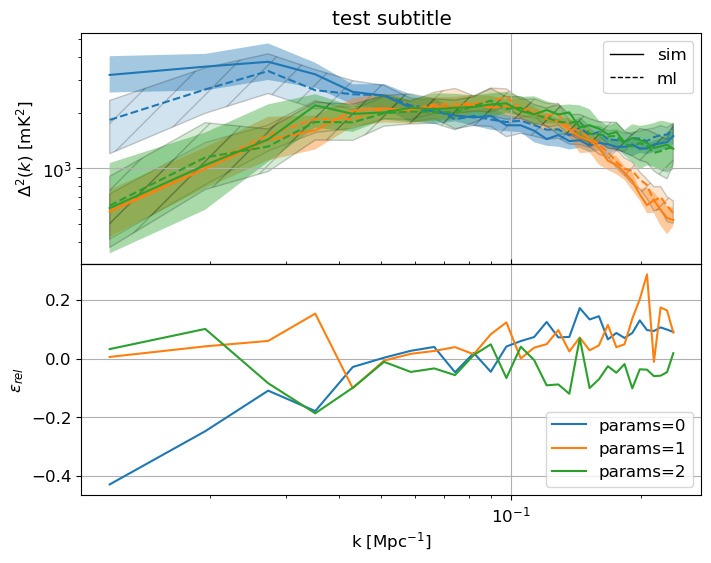

In [94]:
plot_power_spectrum(
    [(Pk_vals_all_sim_0208, Pk_vals_all_ml_0208), 
    (Pk_vals_all_sim_0802, Pk_vals_all_ml_0802),
    (Pk_vals_all_sim_0000, Pk_vals_all_ml_0000)]
    )
# plt.grid()
# plot_power_spectrum(Pk_vals_all_diffusion, Pk_vals_all_diffusion)

torch.Size([192, 1, 64, 64])


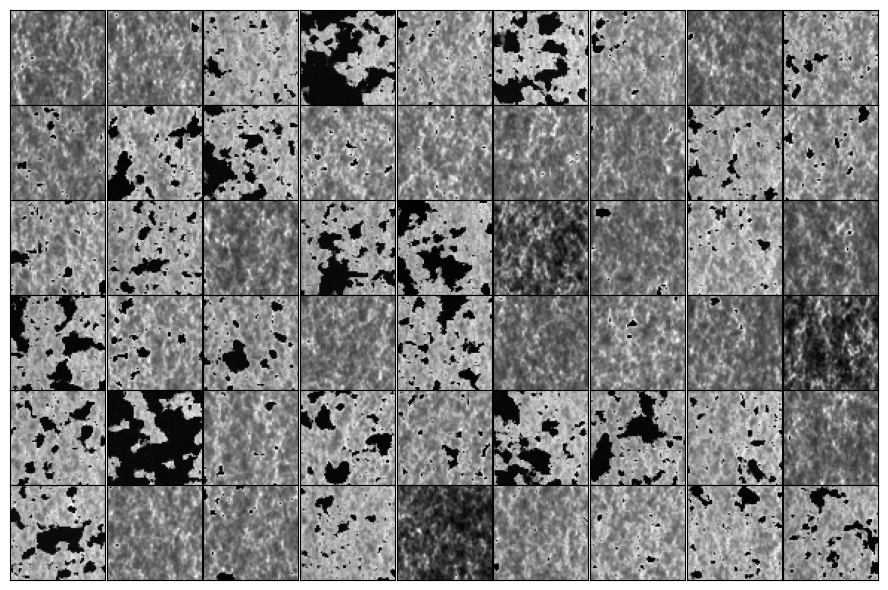

In [14]:
# for i in range(24):
#     plt.imshow(x_ml[i,0])
#     plt.show()
print(x0000_ml.shape)
plot_grid(x0000_ml)

In [15]:
# # print("x_ml.shape =", x_ml.shape)
# # print("x.shape =", x.shape)
# # print("x_ml", x_ml.max(), x_ml.min())
# x_ml_truc = x_ml#torch.where(x_ml < -1, -1, x_ml)
# # print("x_ml", x_ml_truc.max(), x_ml_truc.min())
# Tb_ml = (x_ml_truc[:,0].mean(axis=1) + 1) / 2 *80
# # print("Tb", Tb.max(), Tb.min())


In [16]:
# def unscale(x):
#     x = (x + 1) / 2 * 80
#     return x

# def x2Tb(x):
#     Tb = x[:,0].mean(axis=1)
#     return Tb

In [17]:
# plt.plot(los[0], np.median(Tb, axis=0),'b-', label="simulations' average")
# plt.plot(los[0], np.median(Tb_ml, axis=0),'r--', label="samples' average")

# # plt.plot(los[0,:], Tb[:,0,:].mean(axis=0))
# plt.fill_between(los[0], np.percentile(Tb, 100-sigma_level, axis=0), np.percentile(Tb, sigma_level, axis=0), alpha=0.1, color='b')

# plt.fill_between(los[0], np.percentile(Tb_ml, 100-sigma_level, axis=0), np.percentile(Tb_ml, sigma_level, axis=0), alpha=0.1, color='r')
# # for i in range(24):
# #     plt.plot(los[0,:], Tb_ml[i,0,:], lw=0.3)
# # plt.plot(los[0,:], Tb[1,0,:])
# # plt.plot(los[0,:], Tb[2,0,:])
# # plt.yscale('log')
# # plt.title('Global signal for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
# # plt.title('Global signal for random $\log T_{vir}$, $\zeta$')
# plt.ylabel('Tb [mK]')
# plt.xlabel('z')
# plt.grid()
# # plt.legend()
# # plt.show()

In [79]:
def plot_global_signal(Tb_pairs, sigma_level=68.27, alpha=0.4):
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)
    for i, (x0, x1) in enumerate(Tb_pairs):
        # print(Tb0.shape)
        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        ax[0].fill_between(los[0], np.percentile(Tb0, 100-sigma_level, axis=0), np.percentile(Tb0, sigma_level, axis=0), alpha=alpha, facecolor=f"C{i}")
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        ax[0].fill_between(los[0], np.percentile(Tb1, 100-sigma_level, axis=0), np.percentile(Tb1, sigma_level, axis=0), alpha=alpha*0.5, facecolor=f"C{i}", edgecolor='black', hatch='/')

        ax[0].plot(los[0], y0, linestyle='-', c=f"C{i}")#, label='sim')
        ax[0].plot(los[0], y1, linestyle='--', c=f"C{i}")#, label='diffusion')
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(los[0], (y1-y0)/y0, label=f'params={i}', c=f"C{i}")

    # ax[0].set_xscale('log')
    # ax[0].set_yscale('log')
    ax[0].set_xlabel('$<T_b>$ [mK]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    solid = Line2D([0],[0], color='k', lw=1, linestyle='-', label='sim')
    dashed = Line2D([0],[0], color='k', lw=1, linestyle='--', label='ml')
    legend0 = ax[0].legend(handles=[solid,dashed])
    ax[0].set_title('test subtitle')
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    # ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    ax[1].set_xlabel('Redshift')
    xs = ax[1].secondary_xaxis('top')
    xs.set_xticklabels([])
    # xs.set_xticks([],[])
    ax[1].grid()
    ax[1].legend()
        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()

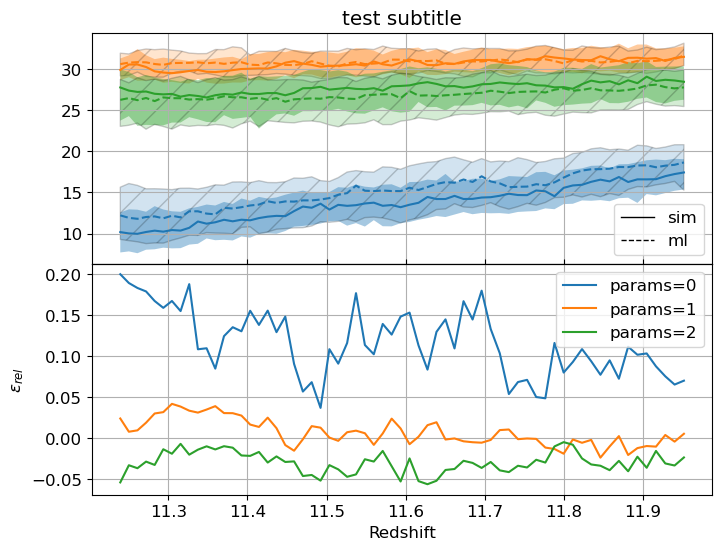

In [80]:
plot_global_signal(
    [(x0208, x0208_ml),
    (x0802,x0802_ml),
    (x0000,x0000_ml)]
    )

In [81]:
x0208.shape

torch.Size([192, 1, 64, 64])

In [82]:
x0208.device

device(type='cpu')

In [83]:
from kymatio.torch import Scattering2D
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# redshifts = np.load('/scratch/dkn16/redshifts_256.npy')
# redshifts = los[0]
# nchunks=6
# GANtbtorch = torch.tensor(total_GAN[0][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
GANtbtorch = x0208.to(device)
x_sim = [x0208, x0802, x0000]
x_ml = [x0208_ml, x0802_ml, x0000_ml]
print(x0000.shape)
# x_ml[0].shape
# Set the parameters of the scattering transform.
J = 6
# M, N = 256,128
M, N = 64, 64
S = Scattering2D(J, (M, N), L=4, out_type='list').cuda()
jthetas = []
for dicts in S(GANtbtorch):
    jthetas.append([dicts['j'], dicts['theta']])
jthetas = np.array(jthetas)
# xlables = []
# # Define a Scattering2D object.

S = Scattering2D(J, (M, N), L=4).cuda()

torch.Size([192, 1, 64, 64])


/scratch/331976/ipykernel_162862/133027632.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


In [84]:
Sgan = []
Stest = []
for i in range(3):
    # GANtbtorch = torch.tensor(total_GAN[i][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
    GANtbtorch = x_sim[i][:,0].to(device)
    # GANtbtorch = x0000[:,0].to(device)
    Sx1 = np.mean(S(GANtbtorch).to('cpu').numpy(),axis=(2,3))
    for j in [0,3,6]:
        index = [a[0] == (j,) for a in jthetas]
        #print(index)
        cache = Sx1[:,index]
        #print(cache.shape)
        if j == 0:
            S1 = cache
        else:
            S1=np.concatenate((S1,cache),axis = 1)
        #xlables.append((j))
        # print('done, i,j =', i,',', j)
    for j in [0,3,6]:
        for j2 in [0,3,6]:
            if j2<j:
                continue
            index = [a[0] == (j,j2) for a in jthetas]
            cache = Sx1[:,index]
            S1=np.concatenate((S1,cache),axis = 1)
            #xlables.append((j2,j))
    print(S1.shape)

    # testtorch = torch.tensor(total_test[i][:,:,nchunks*64:(nchunks+2)*64],device = "cuda",dtype = torch.float32)
    testtorch = x_ml[i][:,0].to(device)
    Sx1 = np.mean(S(testtorch).to('cpu').numpy(),axis=(2,3))

    for j in [0,3,6]:
        index = [a[0] == (j,) for a in jthetas]
        #print(index)
        cache = Sx1[:,index]
        #print(cache.shape)
        if j == 0:
            St = cache
        else:
            St=np.concatenate((St,cache),axis = 1)
        #xlables.append((j))
    for j in [0,3,6]:
        for j2 in [0,3,6]:
            if j2<j:
                continue
            index = [a[0] == (j,j2) for a in jthetas]
            cache = Sx1[:,index]
            St=np.concatenate((St,cache),axis = 1)
            #xlables.append((j2,j))
    St.shape
    Sgan.append(S1)
    Stest.append(St)

(192, 24)
(192, 24)
(192, 24)


<Figure size 4000x1500 with 0 Axes>

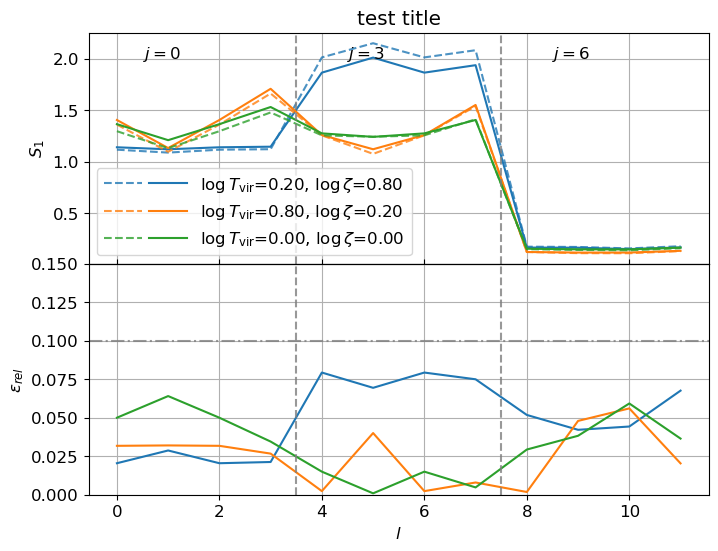

In [86]:
plt.rc('font',family = 'sans-serif',size =12)
fig = plt.figure(dpi=500,figsize = (8,3))
# gs = fig.add_gridspec(2, 1, height_ratios=( 2.5,1),wspace=0.05, hspace=0.0)
# Create the Axes.
# ax = fig.add_subplot(gs[0, 0])

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)

params = [
    (0.2,0.8),
    (0.8,0.2),
    (0,0),
]

#nchunks = 0
colors=['tab:blue','tab:orange','tab:green','tab:red']
legends=[r"$\log T_{\rm vir}$=%.2f, $\log\zeta$=%.2f"%(params[s][0],params[s][1]) for s in range(3)]
legends1 = []

# print("len(Sgan) =", len(Sgan))
# print("len(Stest) =", len(Stest))
for i in range(3):
    Sx1 = Sgan[i]
    #print(Sx1.shape)
    sx1_per = np.percentile(Sx1,[5,95],axis=0)
    line1, = ax[0].plot(np.mean(Sx1,axis=(0))[0:12],c=colors[i],label=legends[i],linestyle='--',alpha = 0.8)
    #ax.fill_between(range(12),sx1_per[0][0:12],sx1_per[1][0:12],color = colors[i],alpha = 0.2)
    
    Sx = Stest[i]
    sx_per = np.percentile(Sx,[5,95],axis=0)
    line2, = ax[0].plot(np.mean(Sx,axis=(0))[0:12],c=colors[i])
    #ax.fill_between(range(12),sx_per[0][0:12],sx_per[1][0:12],color = colors[i],alpha = 0.4)
    legends1.append((line1,line2))
    # print("ax, i =", i)
# ax.set_title(f'z={redshifts[86+nchunks*64+64]:.3f}')
ax[0].set_title(f'test title')
#plt.ylim(0,3.1)
ax[0].set_ylabel(r'$S_1$')
#plt.ylim(0,3.1)
#print(ax.get_ylim())
ax[0].set_ylim(ax[0].get_ylim()[0],ax[0].get_ylim()[1])
for j in range(3):
    ax[0].text(0.5+4*j,2,r'$j={%d}$'%(j*3))

# ax[0].set_xticks(range(12),[a[0] for a in jthetas[1:13][:,1]])
l = ax[0].legend([a for a in legends1],legends,handlelength = 5, handler_map={tuple: HandlerTuple(ndivide=2,)})
ax[0].vlines([3.5,7.5], ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='tab:grey',alpha = 0.8, linestyle='--')
ax[0].grid()

# ax[1] = fig.add_subplot(gs[1, 0],sharex=ax)
# print(len(Stest))
for i in range(3):
    Sx = Stest[i]
    Sx1 = Sgan[i]
    Sx = np.mean(Sx,axis = 0)
    Sx1 = np.mean(Sx1,axis = 0)
    ax[1].plot(np.abs(Sx1[0:12][Sx[0:12]>0.1]/Sx[0:12][Sx[0:12]>0.1]-1),c=colors[i])
    # print("ax1, i =", i)
# xs = ax[1].secondary_xaxis('top')
# xs.set_xticks(range(12),[])
# ax[1].set_yticks([0.0,0.2])

xs = ax[1].secondary_xaxis('top')
xs.set_xticklabels([])
ax[1].set_ylim(ymin=0.0, ymax=0.15)
ax[1].vlines([3.5,7.5],ax[1].get_ylim()[0],ax[1].get_ylim()[1],colors='tab:grey',alpha = 0.8,linestyle='--')
ax[1].set_xlim(ax[1].get_xlim()[0],ax[1].get_xlim()[1])
ax[1].hlines(0.1,ax[1].get_xlim()[0],ax[1].get_xlim()[1],colors='tab:grey',alpha = 0.8,linestyle='-.')

#xs.set_xticks([8,9,10,11],['','','',''])
ax[1].set_xlabel(r'$l$')
ax[1].set_ylabel(r'$\epsilon_{rel}$')
ax[1].grid()
# plt.savefig(f'./tests/S1z={redshifts[86+nchunks*64+64]:.3f}.pdf',bbox_inches='tight')

plt.subplots_adjust(hspace=0)